# Welcome!
This notebook demonstrates how to develop a conversational system that uses a deep knowledge base about hotels, combining structured instance-level data and an ontological model. The knowledge graph (KG) and ontology enable reasoning to enhance dialogue response generation. The task involves integrating a GraphRAG-like approach to query the knowledge base and generate accurate, context-aware responses.

Specifically, the notebook has the following steps:

1. **Setup**: Loading the knowledge graph, dialogues, and required libraries (e.g., OWLAPY).
2. **Analyzing the knowledge graph**: Exploring its structure and entities using OWLAPY queries.
3. **Extending the ontology**: Adding TBox information for expressive reasoning.
4. **Creating dialogues**: Create dialogues based on the examples. Write 5 simple dialogues and 5 more detailed ones to showcase different types of interactions.
5. **Combining ontology and KG data**: Deploying an OWL reasoner to perform class-expression queries.
6. **Query generation with LLMs**: Using an LLM (e.g., Llama3.2) to generate or assist in creating queries against the KG.
7. **Generating responses**: Summarizing retrieved data into dialogue responses using a KG-augmented RAG approach.
8. **Evaluation**: Assessing the system's performance using metrics like intersection-over-union scores.

## Assignment
The goal of this assignment is to develop a logic-enhanced conversational system that retrieves and reasons over domain knowledge to assist in dialogue response generation. You will focus on both the technical aspects of KG+ontology reasoning and the integration with LLMs for robust responses.

### Assignment Steps
1. **Analyze the provided knowledge graph and dialogues**:
   - Explore the KG's entities, properties, and relevance to the dialogues.
   - Identify opportunities where ontology reasoning enhances dialogue responses.
2. **Extend the ontology**:
   - Add expressive TBox information to support meaningful inferences.
3. **Deploy the reasoning environment**:
   - Use OWLAPY to combine the KG (as ABox) with the ontology for reasoning-based queries.
4. **Generate class-expression queries**:
   - Use instruction-based, few-shot prompting with Llama3.2 to produce or assist in creating the queries.
5. **Summarize results into dialogue responses**:
   - Apply KG-augmented RAG to generate user-facing answers based on reasoning results.
6. **Evaluate the system**:
   - Use appropriate metrics, including intersection-over-union scores for set-based answers.

## Report
Write a **5-page report** in LNCS format that includes:

1. **Introduction**: Background on conversational systems with LLMs and the role of reasoning over domain knowledge.
2. **Methodology**: A detailed description of your approach, including diagrams and examples.
3. **Results**: Evaluation findings from the implemented steps.
4. **Discussion**: Strengths and weaknesses of your approach, lessons learned, and potential improvements.

Make sure to use the following template: [Springer Lecture Notes in Computer Science](https://www.overleaf.com/latex/templates/springer-lecture-notes-in-computer-science/kzwwpvhwnvfj)


## Grading
Your work will be evaluated based on:

1. **Code Implementation (30%)**: Quality and functionality of the logic-enhanced conversational system.
2. **Report (70%)**: Depth of analysis and clarity in presenting methods, results, and lessons learned.

## Kaggle Environment Notes
To ensure smooth execution:
- Load the required data into `/kaggle/input/`.
- Use `/kaggle/working/` for saving temporary files.
- Turn on GPUs and internet connectivity when necessary, and follow best practices for resource management.

In [42]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python

# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input director

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/rdf-ontology/data.rdf
/kaggle/input/ontology-data/data.ttl


# Install packages

In [ ]:
!pip install jpype1==1.5.2
!pip install owlapy==1.5.1 
!pip install ollama

# Import libraries


In [44]:
from owlapy import manchester_to_owl_expression, dl_to_owl_expression
from owlapy.iri import IRI
from owlapy.owl_ontology import Ontology
from owlapy.owl_reasoner import SyncReasoner, StructuralReasoner


import matplotlib.pyplot as plt
from collections import Counter

# 1. Analyze the provided knowledge graph (data.ttl).

## Loading ontology

In [45]:
from pathlib import Path
from owlapy.iri import IRI
from owlapy.owl_ontology import Ontology

path = Path("/kaggle/input/rdf-ontology/data.rdf")

# hard sanity checks
print("Exists:", path.exists())
print("Size (bytes):", path.stat().st_size)

onto = Ontology(IRI.create(path.as_uri()), load=True)

print("Ontology loaded successfully.")


Exists: True
Size (bytes): 1071766
Ontology loaded successfully.


In [46]:
print("Classes:", len(list(onto.classes_in_signature())))
print("Object properties:", len(list(onto.object_properties_in_signature())))
print("Data properties:", len(list(onto.data_properties_in_signature())))
print("Individuals:", len(list(onto.individuals_in_signature())))


Classes: 34
Object properties: 9
Data properties: 0
Individuals: 1746


## Helpers for analysis ontology

In [36]:
def get_label(entity, ontology) -> str:
    """
    Get the rdfs:label for an entity from the ontology.
    Falls back to extracting local name from IRI if no label exists.
    """
    # Get the IRI first
    if hasattr(entity, "get_iri") and callable(entity.get_iri):
        iri_obj = entity.get_iri()
    elif hasattr(entity, "iri"):
        iri_obj = entity.iri
    else:
        return str(entity)
    
    # Try to get rdfs:label from the underlying owlready2 ontology
    try:
        # Access the underlying owlready2 world
        owlready_onto = ontology._onto
        
        # Get IRI as string
        if hasattr(iri_obj, "as_str") and callable(iri_obj.as_str):
            iri_str = iri_obj.as_str()
        else:
            iri_str = str(iri_obj)
        
        # Search for entity in owlready2 ontology and get its label
        with owlready_onto:
            entity_obj = owlready_onto.world.search_one(iri=iri_str)
            if entity_obj and hasattr(entity_obj, 'label') and entity_obj.label:
                # Return first label (they're usually lists)
                labels = entity_obj.label
                if labels and len(labels) > 0:
                    return str(labels[0])
    except:
        pass
    
    # Fallback: extract local name from IRI
    if hasattr(iri_obj, "as_str") and callable(iri_obj.as_str):
        iri_str = iri_obj.as_str()
    else:
        iri_str = str(iri_obj)

    return iri_str.rstrip("/").rsplit("/", 1)[-1]

## Plotting and analysis


Ontology summary

Classes:           34
Object properties: 9
Data properties:   0
Individuals:       1746


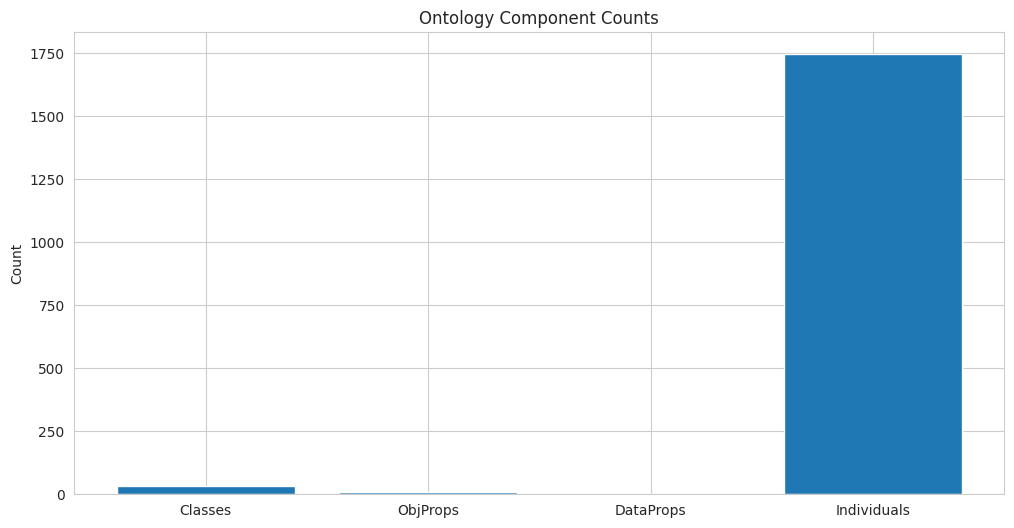



Individual type distribution (direct/asserted)

Unique classes with >=1 typed instance: 28

Top 15 classes by instance count:
             Class  Count
        Restaurant    506
             Hotel    344
      Camping Site    342
            Hostel    314
     Neighbourhood    267
            Museum     55
              City     34
      Trainstation     22
             River     12
       Nationality     10
          Facility      8
Tourist Attraction      8
           Country      5
   Restaurant Type      5
       User Rating      5


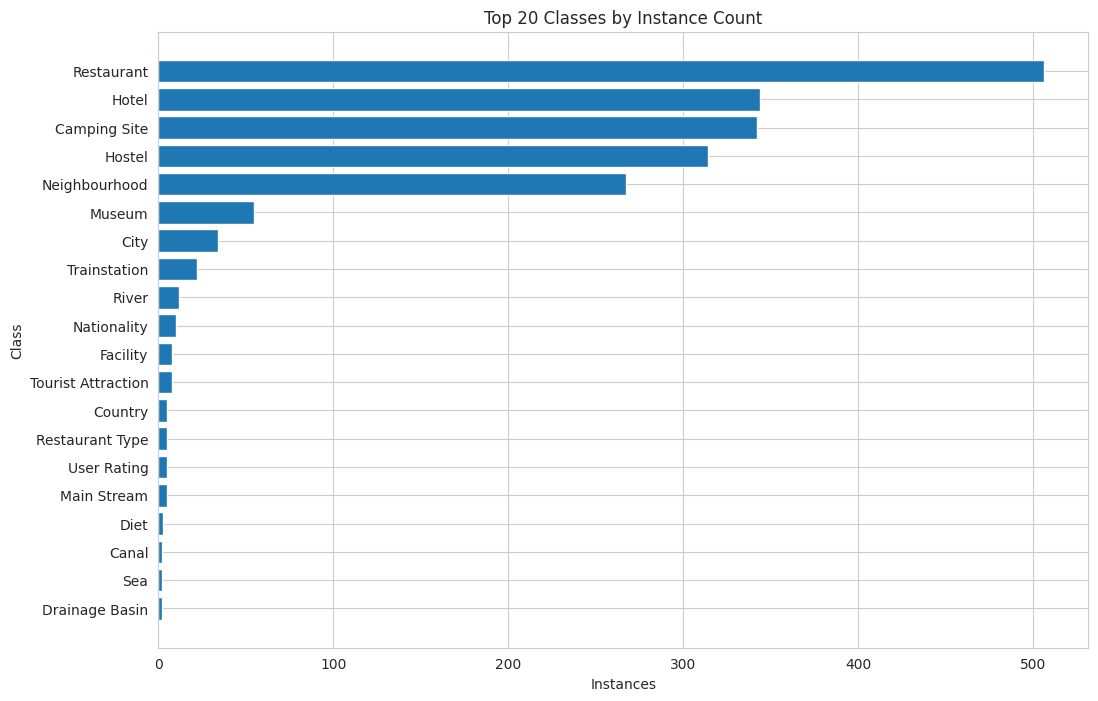

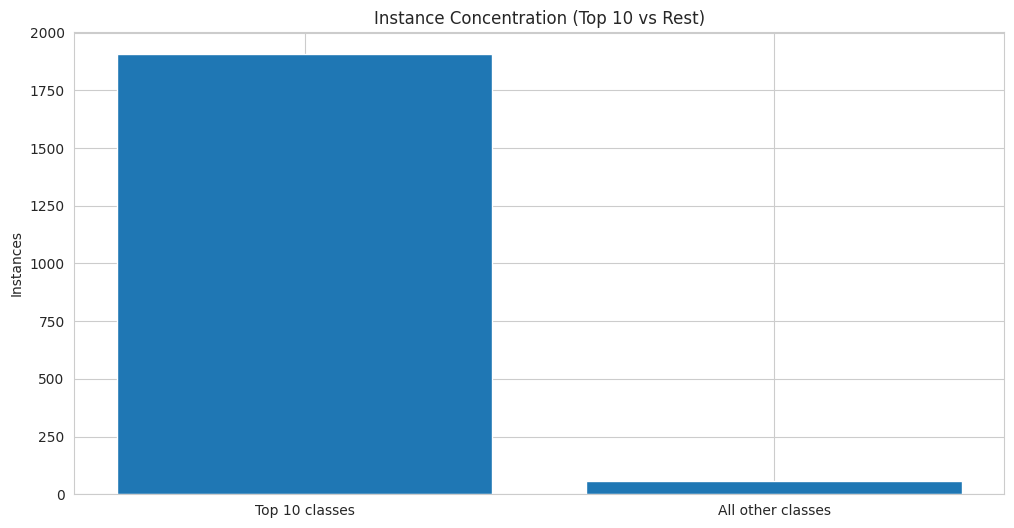


Class hierarchy structure

Top 15 classes by number of subclasses (descendants):
                 Class  NumSubclasses
             WaterBody             12
 AccommodationEntities              5
                 Hotel              2
TransportationEntities              2
          Luxury Hotel              1
              Facility              0
           Nationality              0
       Restaurant Type              0
            Restaurant              0
                  City              0
               Airport              0
          Camping Site              0
                  Diet              0
                Hostel              0
              Landmark              0


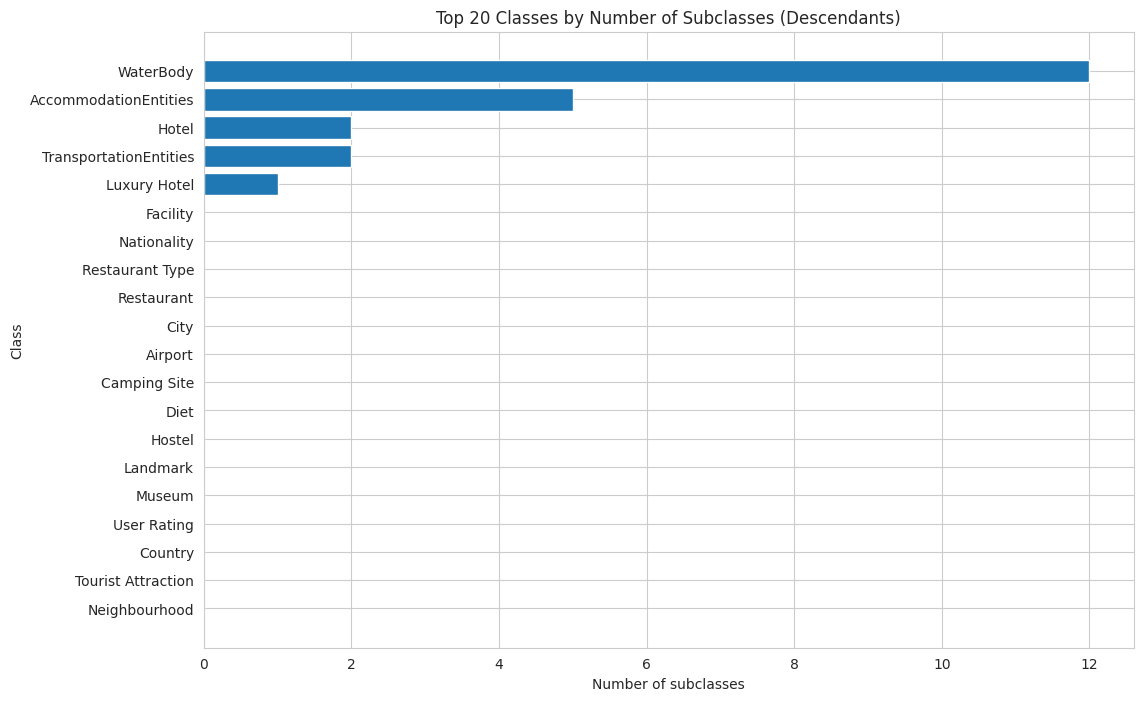

,Class,Count
0,Restaurant,506
1,Hotel,344
2,Camping Site,342
3,Hostel,314
4,Neighbourhood,267
5,Museum,55
6,City,34
7,Trainstation,22
8,River,12
9,Nationality,10


,Class,NumSubclasses
0,WaterBody,12
1,AccommodationEntities,5
2,Hotel,2
3,TransportationEntities,2
4,Luxury Hotel,1
5,Facility,0
6,Nationality,0
7,Restaurant Type,0
8,Restaurant,0
9,City,0



Analysis complete!


In [47]:
plt.rcParams["figure.figsize"] = (12, 6)

reasoner = StructuralReasoner(onto) # Not an actual reasoner, from docs: Tries to check instances fast (but maybe incomplete).

# Pull signatures once
classes = list(onto.classes_in_signature())
object_props = list(onto.object_properties_in_signature())
data_props = list(onto.data_properties_in_signature())
individuals = list(onto.individuals_in_signature())

'''Quick ontology summary'''

print("=" * 70)
print("\nOntology summary\n")
print("=" * 70)

print(f"Classes:           {len(classes)}")
print(f"Object properties: {len(object_props)}")
print(f"Data properties:   {len(data_props)}")
print(f"Individuals:       {len(individuals)}")

plt.figure()
plt.bar(
    ["Classes", "ObjProps", "DataProps", "Individuals"],
    [len(classes), len(object_props), len(data_props), len(individuals)]
)
plt.title("Ontology Component Counts")
plt.ylabel("Count")
plt.show()

'''Individual type distribution'''

print("\n" + "=" * 70)
print("\nIndividual type distribution (direct/asserted)\n")
print("=" * 70)

type_counter = Counter()

for ind in individuals:
    ind_types = reasoner.types(ind, direct=True)
    for cls in ind_types:
        type_counter[get_label(cls, onto)] += 1

type_df = (
    pd.DataFrame(type_counter.items(), columns=["Class", "Count"])
    .sort_values("Count", ascending=False)
    .reset_index(drop=True)
)

print(f"Unique classes with >=1 typed instance: {len(type_df)}")
if len(type_df) > 0:
    print("\nTop 15 classes by instance count:")
    print(type_df.head(15).to_string(index=False))

    # Plot top typed classes
    top_n = min(20, len(type_df))
    top = type_df.head(top_n).iloc[::-1]
    plt.figure(figsize=(12, 8))
    plt.barh(top["Class"], top["Count"])
    plt.title(f"Top {top_n} Classes by Instance Count")
    plt.xlabel("Instances")
    plt.ylabel("Class")
    plt.show()

    top10 = int(type_df.head(min(10, len(type_df)))["Count"].sum())
    rest = int(type_df.iloc[10:]["Count"].sum()) if len(type_df) > 10 else 0

    plt.figure()
    plt.bar(["Top 10 classes", "All other classes"], [top10, rest])
    plt.title("Instance Concentration (Top 10 vs Rest)")
    plt.ylabel("Instances")
    plt.show()
else:
    print("\nNo asserted rdf:type/class assertions found.")

'''Class hierarchy structure'''

print("\n" + "=" * 70)
print("Class hierarchy structure")
print("=" * 70)

sub_counts = []
for c in classes:
    subs = reasoner.sub_classes(c, direct=False)
    subs = set(subs)
    if c in subs:
        subs.remove(c)
    sub_counts.append((get_label(c, onto), len(subs)))

sub_df = (
    pd.DataFrame(sub_counts, columns=["Class", "NumSubclasses"])
    .sort_values("NumSubclasses", ascending=False)
    .reset_index(drop=True)
)

print("\nTop 15 classes by number of subclasses (descendants):")
print(sub_df.head(15).to_string(index=False))

top_n = min(20, len(sub_df))
top = sub_df.head(top_n).iloc[::-1]
plt.figure(figsize=(12, 8))
plt.barh(top["Class"], top["NumSubclasses"])
plt.title(f"Top {top_n} Classes by Number of Subclasses (Descendants)")
plt.xlabel("Number of subclasses")
plt.ylabel("Class")
plt.show()

'''show full panda tables '''

if len(type_df) > 0:
    display(type_df.head(50))

display(sub_df.head(50))

print("\nAnalysis complete!")

# 2. Create a small ontology that can support expressive inference about hotels and analyse the dialogues (examples.txt).

# Create your own dialogues

Once you have created your ontology, use it as the foundation for designing dialogues. Study the examples in examples.txt to understand their structure and content. Then, create 10 dialogues of your own, ensuring a range of difficulty levels: 5 simple ones and 5 more challenging ones. These dialogues should illustrate how your ontology can support reasoning and should include references to the types of information modeled in your ontology.

In [ ]:
# Create 10 dialoges based on the description
dialogue1: str = ""
dialogue2: str = ""
dialogue3: str = ""
dialogue4: str = ""
dialogue5: str = ""
dialogue6: str = ""
dialogue7: str = ""
dialogue8: str = ""
dialogue9: str = ""
dialogue10: str = ""
dialogues: list = [dialogue1, dialogue2, dialogue3, dialogue4, dialogue5, dialogue6, dialogue7, dialogue8, dialogue9, dialogue10]

# 3. Deploy a reasoning environment

In [ ]:
ontology_path: str = "..." # your path (Kaggle, Colab or local)

In [ ]:
# TODO: load your ontology and create reasoner

# 4. Instruct the LLM to produce the query or components of the query (e.g., keywords) against the KG

In [ ]:
#Download ollama
# For Kaggle or Linux: download with this command, for Windows & Mac locally, download executable from website
!curl -fsSL https://ollama.com/install.sh | sh

import subprocess
process = subprocess.Popen("ollama serve", shell=True) #runs on a different thread

#Download Python library
!pip install ollama

In [ ]:
# Import ollama & pull LLM
import ollama
!ollama pull llama3.2
model: str = "llama3.2"

In [ ]:
#Step 1: Write the instruction for the LLM - remember the overarching topic (assistance with hotels), as well as the fact that
# this step is meant to merely extract queries from the user input.

# Instruct LLM
instruction: str = "..."

In [ ]:
#Step 2: Write a function that takes the model, instruction and one user question as input, runs the LLM and outputs its response
def question_to_query(instruction: str, question: str, model="llama3.2") -> str:
    '''
    This function is meant to use the instruction defined above to run the LLM in order to convert one user input
    question into a query for the ontology reasoner.
    Parameters: instruction (string), question (string), model version (string)
    Returns: LLM response (string)
    '''
    # TODO

In [ ]:
#Step 3: Run the LLM for each example defined above

# Helper function
def find_between(s: str, start: str, end: str) -> str:
    return s.split(start)[1].split(end)[0]

for dialogue in dialogues:
    print("User question:", dialogue)
    print()
    result: str = question_to_query(instruction, dialogue, model)
    # Possibly only extract the relevant parts
    print("Extracted query:", result)
    queries.append(result)
    print()

# 5. Use an LLM to summarize some result into a natural language response to the user.

In [ ]:
#Step 1: Extract knowledge from query with the reasoner and return as list
def reason(query: str) -> list:
    '''
    This function should convert a query into an OWL expression and use the reasoner
    to return the answers.
    '''
    # TODO

In [ ]:
#Step 2: Instruct & run the LLM for the new task: transform the extracted knowledge into a natural language response based
# on the original question
def knowledge_to_response(question: str, knowledge: str, model="llama3.2"):
    '''
    This function is meant to write an instruction based on an item of extracted knowledge and the original user
    question, and run the LLM to summarize a response.
    '''
    # TODO

In [ ]:
#Step 3: Combine everything: generate queries from the dialogues, extract knowledge from queries with the reasoner and
# generate summary responses

# 6. Evaluate your LLM

In [ ]:
# TODO: your code to implement and demonstrate evaluation metrics
# Suggestions: comparison of generated queries with the queries manually created in examples.txt, Intersection Over Union,
# but you can be creative here